In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None #remove warning masseges from panda
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #stationary test
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA #this package doesn't work anymore and was switched to the one underneth
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima.arima import auto_arima

In [2]:
POS = pd.read_csv('C:/Users/althy/Desktop/Graduation Project/Graduation_Project-main/POS_monthly_transactions.csv')

In [3]:
POS = pd.DataFrame(POS)

<h4> Exploring and cleaning Data

In [4]:
POS.head(5)

,Date,Total
0,01/2016,38692.210
1,02/2016,36435.679
2,03/2016,40522.562
3,04/2016,40782.271
4,05/2016,46328.771


In [5]:
POS.describe()

,Total
count,83.000000
mean,222660.357627
std,198570.973077
min,36435.679000
25%,63499.604000
50%,121834.258000
75%,363648.666500
max,669108.839000


In [6]:
#checking for Nan values
POS.isna().values.any()

True

In [7]:
POS[POS.Date.isna()]

,Date,Total
83,NaN,NaN
84,NaN,NaN
85,NaN,NaN


seeing the NaN rows we can conclude that they are a mistake, so we can remove them

In [8]:
clean_POS = POS.dropna()

In [9]:
#checking for duplicated in date column.
clean_POS.Date.duplicated().values.any()

False

C:\Users\althy\AppData\Local\Temp\ipykernel_14704\3259346624.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.lineplot(x="Date", y="Total",


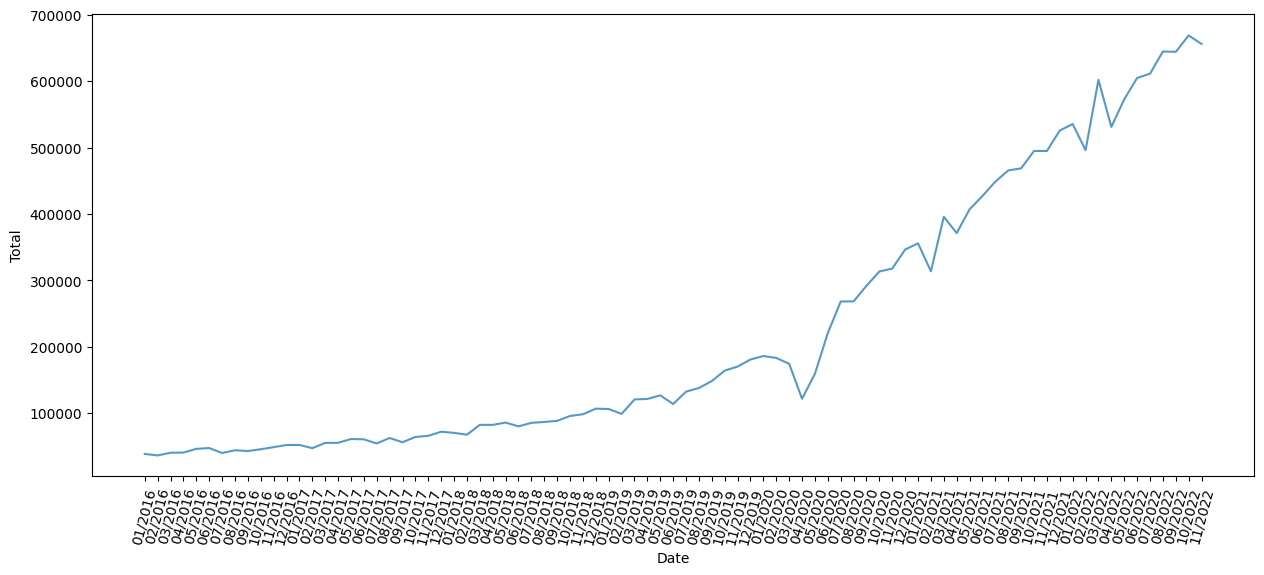

In [10]:
#making line plot 
plt.xticks(rotation=75)
fig = plt.gcf()
fig.set_size_inches(15, 6)
scatter = sns.lineplot(x="Date", y="Total", 
                          sizes=(40, 800), alpha=0.75, palette="BrBG", legend=False,
                          data=clean_POS)
plt.show()

In [11]:
clean_POS.index = clean_POS.Date
clean_POS = clean_POS.drop('Date', axis=1)

In [12]:
clean_POS.index = pd.to_datetime(clean_POS.index)

<h3> Testing stationary

In [13]:
#function to test statonarity using Dickey-fuller test and ploting it 
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=6).mean()
    movingSTD = timeseries.rolling(window=6).std()
    
    #Plot rolling statistics
    fig = plt.gcf()
    fig.set_size_inches(15, 5)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [44]:
#function to test statonarity using Dickey-fuller test and ploting it 
#def test_stationarity(timeseries):
#    adf_stat, pvalue, _, _, _, _ = adfuller(timeseries.Total)
 #   print("p-value: {:.3f}".format(pvalue))
  #  if pvalue < 0.05:
   #     print("Reject null hypothesis; time series is stationary.")
    #else:
     #   print("Fail to reject null hypothesis; time series may not be stationary.")

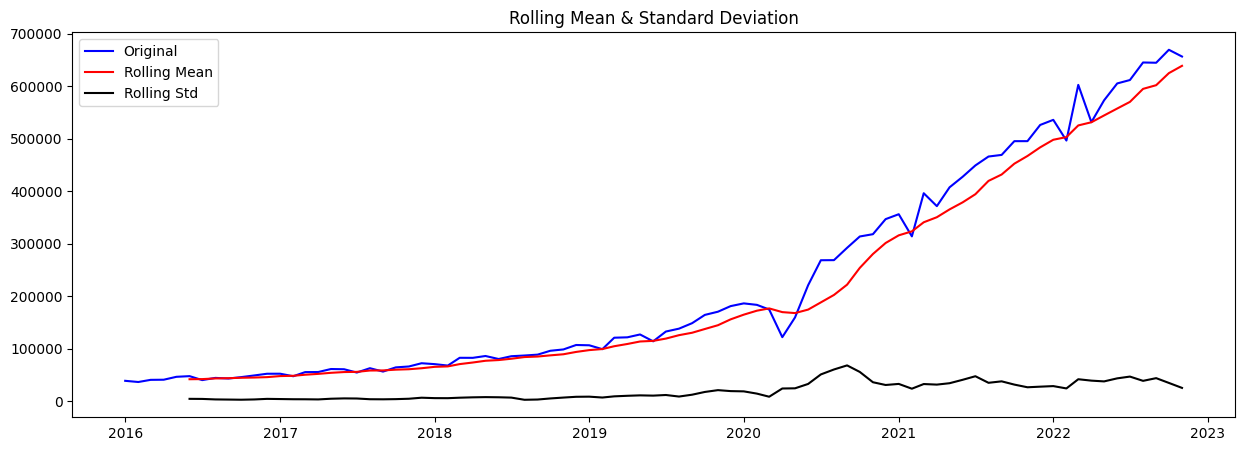

Results of Dickey Fuller Test:
Test Statistic                  0.127514
p-value                         0.967890
#Lags Used                     12.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [15]:
test_stationarity(clean_POS)

<h4> since p-value > 0.05 it's not stationary
so we will try transforming it with taking the first difference

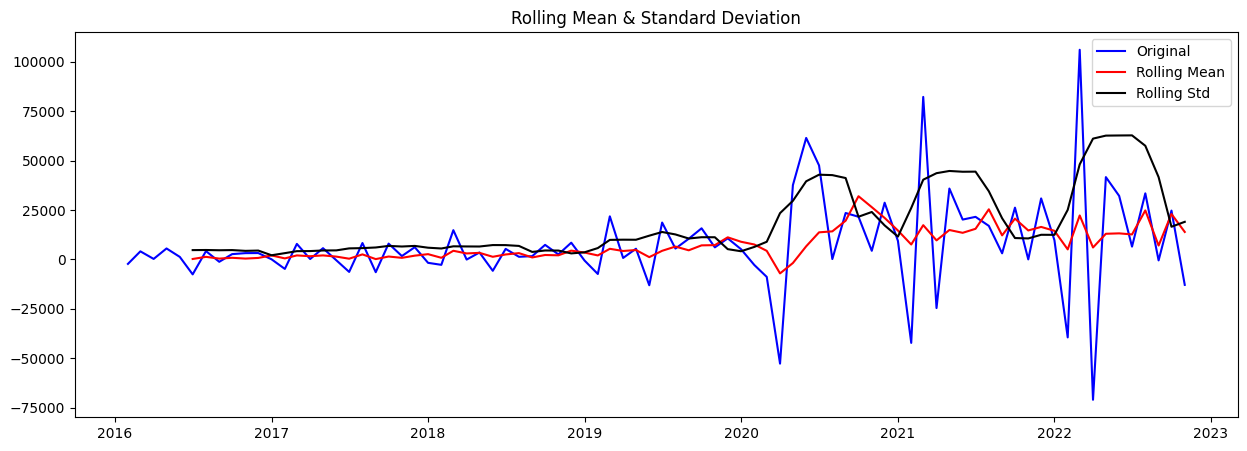

Results of Dickey Fuller Test:
Test Statistic                 -1.089214
p-value                         0.719354
#Lags Used                     12.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [16]:
clean_POS_diff = clean_POS.Total.diff().dropna()
test_stationarity(clean_POS_diff)

In [17]:
clean_POS.head(3)

,Total
Date,
2016-01-01,38692.210
2016-02-01,36435.679
2016-03-01,40522.562


<h5> p-value still high, so we will transform the data again by taking the second diffrence <h5>

In [74]:
clean_POS_diff = pd.DataFrame(clean_POS_diff)

In [66]:
clean_POS_Sec_diff = pd.DataFrame(clean_POS_diff.Total.diff(12).dropna())

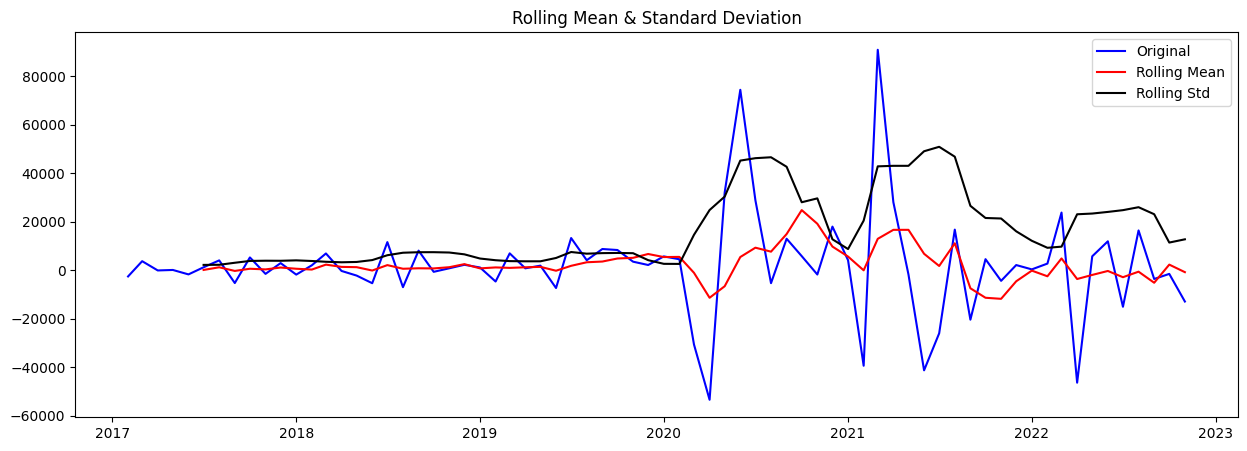

Results of Dickey Fuller Test:
Test Statistic                -7.227424e+00
p-value                        2.035813e-10
#Lags Used                     1.000000e+00
Number of Observations Used    6.800000e+01
Critical Value (1%)           -3.530399e+00
Critical Value (5%)           -2.905087e+00
Critical Value (10%)          -2.590001e+00
dtype: float64


In [67]:
test_stationarity(clean_POS_Sec_diff)

<h4> since 0.05 > p-value, data is stationary after the second diffrence <h4>

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


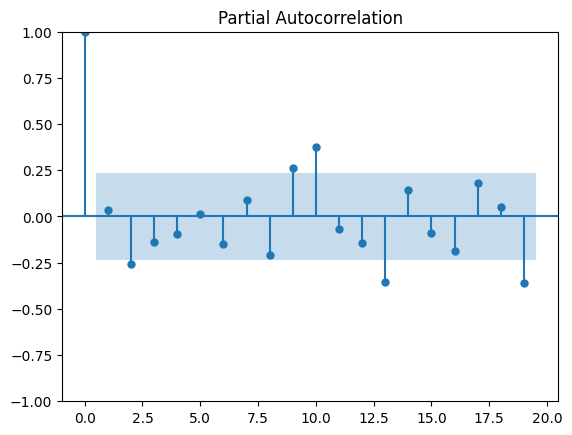

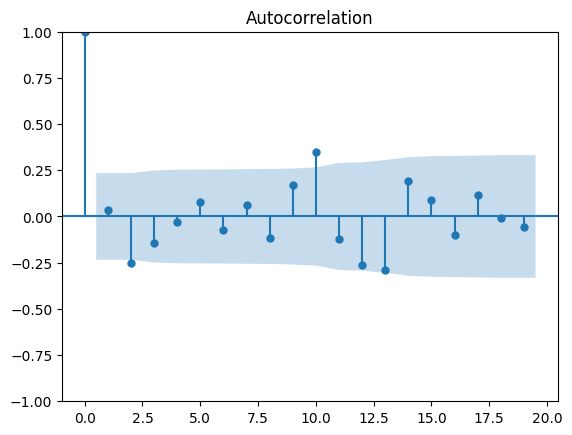

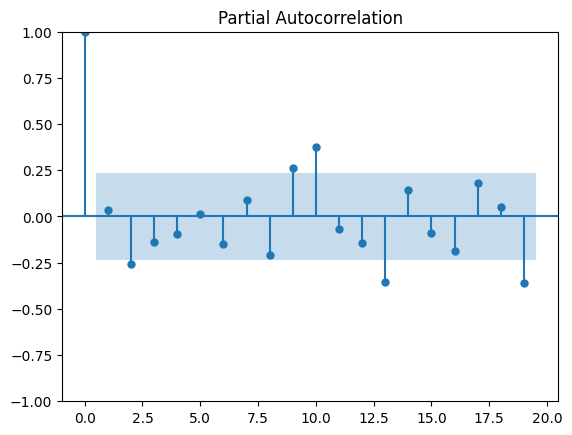

In [68]:
#ACF & PACF plots
plot_acf(clean_POS_Sec_diff.Total)
plot_pacf(clean_POS_Sec_diff.Total)

<h5> another Transformation

In [75]:
clean_POS_diff_log = pd.DataFrame(np.log(clean_POS_diff))

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


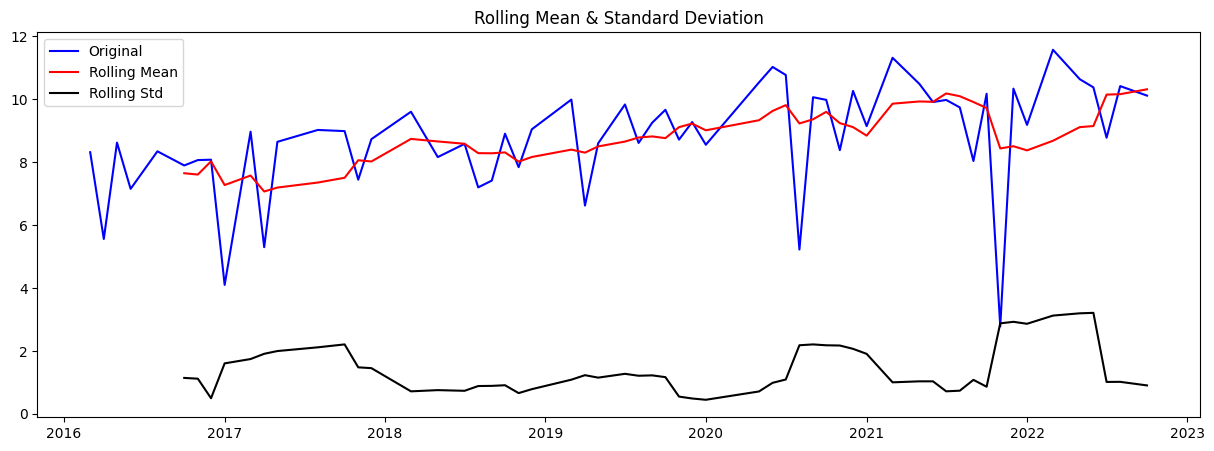

Results of Dickey Fuller Test:
Test Statistic                -7.202140e+00
p-value                        2.350414e-10
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64


In [76]:
test_stationarity(clean_POS_diff_log.dropna())

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


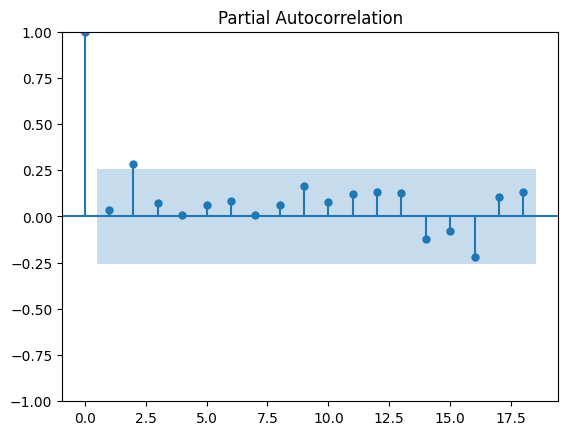

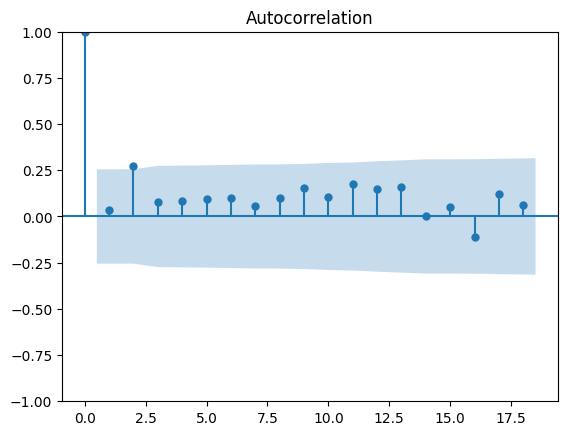

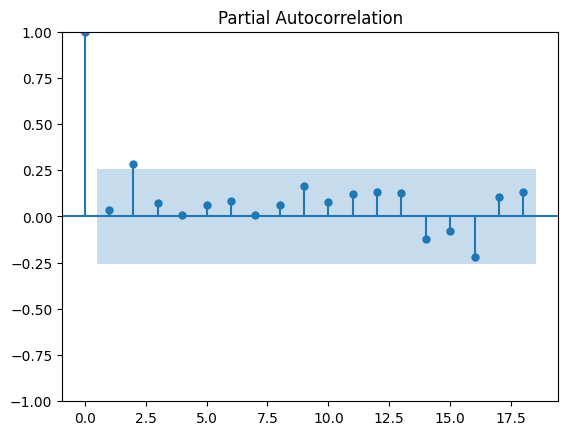

In [79]:
plot_acf(clean_POS_diff_log.dropna())
plot_pacf(clean_POS_diff_log.dropna())

<h4> from the ACF and PACF we conclude that ARIMA model is (1,2,1)<h4>
<h4> to make sure that I have the best model, I'll test it against diffrent model using AIC and BIC

In [25]:
def assess_arima(model):
    AIC = model.aic
    BIC = model.bic
    KPI = {
        'AIC':AIC,
        'BIC':BIC,
        }   
    for key in KPI:
        print(key, '=', KPI[key])

In [80]:
model = ARIMA(clean_POS_diff_log, order=(1,2,1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   70
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -794.954
Date:                Wed, 08 Mar 2023   AIC                           1595.908
Time:                        18:12:41   BIC                           1602.567
Sample:                    02-01-2017   HQIC                          1598.546
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3476      0.114     -3.040      0.002      -0.572      -0.123
ma.L1         -0.9847      0.145     -6.802      0.000      -1.268      -0.701
sigma2      1.123e+09   1.27e-10   8.85e+18      0.0

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [81]:
assess_arima(ARIMA(clean_POS_diff_log, order=(0,2,1)).fit())

AIC = 1600.1320689024365
BIC = 1604.5710843127886


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [82]:
assess_arima(ARIMA(clean_POS_diff_log, order=(1,2,0)).fit())

AIC = 1637.0798150155656
BIC = 1641.5188304259177


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [83]:
assess_arima(ARIMA(clean_POS_diff_log, order=(2,2,0)).fit())

AIC = 1621.6194498741218
BIC = 1628.2779729896502


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [84]:
assess_arima(ARIMA(clean_POS_diff_log, order=(2,2,2)).fit())

AIC = 1573.8270622787977
BIC = 1584.9246008046782


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [85]:
another_model = assess_arima(ARIMA(clean_POS_Sec_diff, order=(0,2,2)).fit())

AIC = 1563.0729228772498
BIC = 1569.7314459927782


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
clean_POS_diff_log = pd.DataFrame(np.log(clean_POS_diff))

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<h5> from the result we find that ARIMA(0,2,2) has lower AIC and BIC, we will use it as alternative model, will make the train/test with both model 

In [32]:
def KPI(test_data,y_pred):
    mae = mean_absolute_error(y_true=test_data, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=test_data, y_pred=y_pred)
    mse = mean_squared_error(y_true=test_data, y_pred=y_pred)
    rmse = np.sqrt(mse)
    #corr = np.corrcoef(y_pred.Total, test_data.Total)
    KPI = {
        'mape':mape,
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        #'corr':corr
    }   
    for key in KPI:
        print(key, '=', KPI[key])

In [33]:
split_index = int(0.80 * len(clean_POS_diff_log))
train_data = clean_POS_diff_log.iloc[:split_index, :]
test_data = clean_POS_diff_log.iloc[split_index:, :]


In [34]:
model = ARIMA(train_data, order=(1,2,1)).fit()
y_pred = pd.DataFrame(index= test_data.index)
y_pred['Total'] = model.forecast(len(test_data)).values

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [35]:
# Use the fitted model to forecast future values
forecast_log_diff = model.forecast(steps=len(test_data))[0]

# Redo the transformation of the forecast by undoing the logarithmic transformation and then undoing the differencing
forecast_log = pd.Series(forecast_log_diff, index=test_data.index)
forecast_diff_reconstructed = np.exp(pd.Series(clean_POS.iloc[-1], index=[clean_POS.index[-1]])\
                                .append(forecast_log)\
                                .cumsum())
forecast_reconstructed = forecast_diff_reconstructed.diff().shift(-1).dropna()

C:\Users\althy\AppData\Local\Temp\ipykernel_14704\2934373688.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_diff_reconstructed = np.exp(pd.Series(clean_POS.iloc[-1], index=[clean_POS.index[-1]])\


In [36]:
#KPI(test_data.dropna(),y_pred)

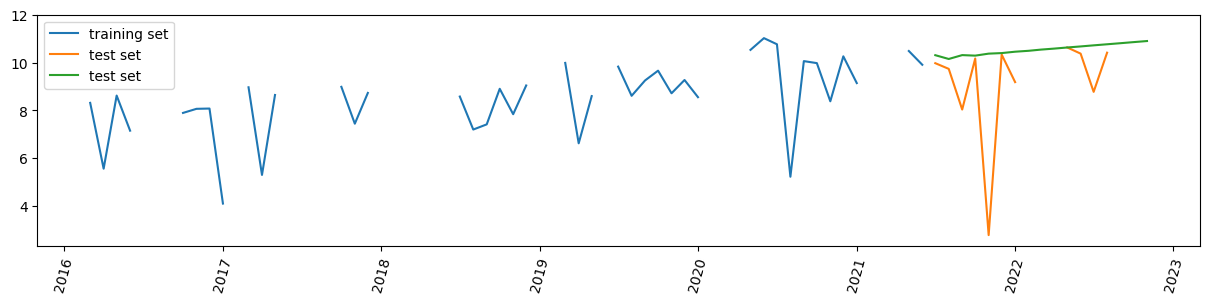

In [37]:
fig = plt.gcf()
fig.set_size_inches(15, 3)
plt.plot(train_data, label = 'training set')
plt.plot(test_data, label='test set')
plt.plot(y_pred.Total, label='test set')
plt.xticks(rotation=75)
plt.legend()
plt.show() 

In [38]:
#retransform_y_pred = np.exp(y_pred) 

In [39]:
#retransform_y_pred

In [41]:
retransform_y_pred = np.exp(np.cumsum(y_pred)) 

In [42]:
retransform_y_pred

,Total
Date,
2021-07-01,3.008690e+04
2021-08-01,7.721983e+08
2021-09-01,2.330622e+13
2021-10-01,6.881572e+17
2021-11-01,2.208963e+22
2021-12-01,7.256263e+26
2022-01-01,2.525313e+31
2022-02-01,9.127791e+35
2022-03-01,3.465861e+40


In [ ]:
retransform_y_pred

,Total
Date,
2021-07-01,30086.900144
2021-08-01,55752.498843
2021-09-01,85934.148295
2021-10-01,115460.911126
2021-11-01,147560.590826
2021-12-01,180409.778679
2022-01-01,215211.617396
2022-02-01,251356.808225
2022-03-01,289327.228475


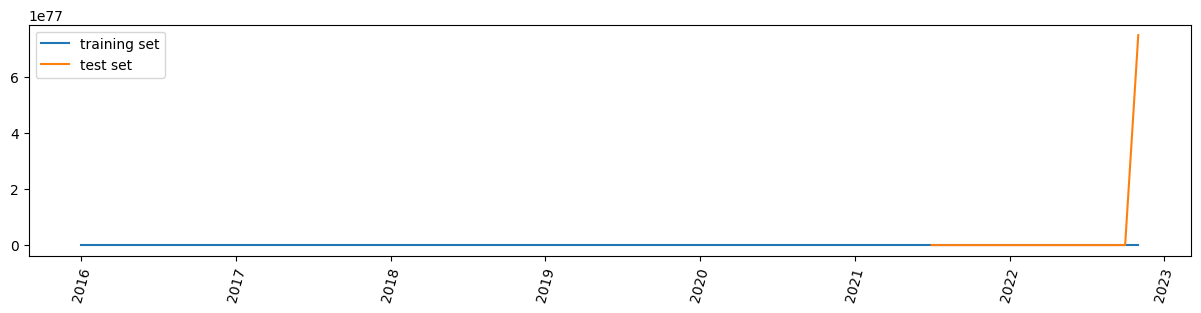

In [43]:
fig = plt.gcf()
fig.set_size_inches(15, 3)
plt.plot(clean_POS, label = 'training set')
plt.plot(retransform_y_pred , label='test set')
plt.xticks(rotation=75)
plt.legend()
plt.show() 